## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

_An AB test was conducted to test the performance of an old website page compared to a newly developed website page using bootstrapping for hypothesis testing._

<a id='probability'></a>
### Part I - Probability

To get started, let's import our libraries.

In [63]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Read in the dataset and take a look at the top few rows here:

In [64]:
# read dataset
df = pd.read_csv('ab_data.csv')

# inspect dataset
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Find the number of rows in the dataset.

In [65]:
# we use shape function to see number of rows [first element]
df.shape[0]

294478

Find the number of unique users in the dataset.

In [66]:
#use unique() function
df['user_id'].nunique()

290584

Proportion of users converted.

In [67]:
df['converted'].mean()
#df.describe()

0.11965919355605512

The number of times the `new_page` and `treatment` don't line up.

In [68]:
df2 = df.query("(group == 'control' and landing_page == 'new_page') or (group == 'treatment' and landing_page == 'old_page')") 
df2.shape[0]

3893

Do any of the rows have missing values?

In [69]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

Identify the number of mismatches for new_page and treatment don't line up

In [70]:
treat_old = df[(df.group == 'treatment') & (df.landing_page == 'old_page')]
treat_old.shape[0]

1965

In [71]:
ctl_new = df[(df.group == 'control') & (df.landing_page == 'new_page')]
ctl_new.shape[0]

1928

In [72]:
treat_old.shape[0] + ctl_new.shape[0]

3893

Because these instances are uninterpretable, they will be removed from the dataset at a later point.

In [73]:
remove = ctl_new.append(treat_old).index
remove

Int64Index([    22,    240,    490,    846,    850,    988,   1198,   1354,
              1474,   1877,
            ...
            293240, 293302, 293391, 293443, 293530, 293773, 293817, 293917,
            294014, 294252],
           dtype='int64', length=3893)

In [74]:
df2 = df.drop(remove)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [75]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Identify unique users for new df

In [76]:
df2['user_id'].nunique()

290584

There is one **user_id** repeated in **df2**.  What is it?

In [77]:
df2[df2.duplicated(['user_id'])]['user_id'].unique()

array([773192])

What is the row information for the repeat **user_id**? 

In [78]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [79]:
df2 = df2.drop_duplicates(['user_id'], keep='first')

Confirm the converted mean for the new df

In [80]:
convert_mean = df2.converted.mean()
convert_mean

0.11959708724499628

Conversion rate for control group/old page

In [81]:
control_convert = df2[df2['group'] == 'control']['converted'].mean()
control_convert

0.1203863045004612

Conversion rate for treatment group/new page

In [82]:
treat_convert = df2[df2['group'] == 'treatment']['converted'].mean()
treat_convert

0.11880806551510564

Probability that an individual received the new page?

In [83]:
p_new_page = (df2['landing_page'] == 'new_page').mean()
p_new_page

0.50006194422266881

The proportions of each page are balanced and so no additional manipulation is required to balance for impacts of uneven weightings between the pages.

__Observations:__ These results suggest that there is not sufficient evidence to say that the treatment page leads to more conversions as the probability of conversion for the treatment group is less than that for the control group.

<a id='ab_test'></a>
## Part II - A/B Test - Hypotheses

$$ H_0 : p_{new} - p_{old}$$

Conversion rate for $p_{new}$ and $p_{new}$ under the null

**Convert rate** for $p_{new}$ under the null

In [84]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

**Convert rate** for $p_{old}$ under the null

In [85]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

$n_{new}$

In [86]:
n_new = df2[df2['group'] == 'treatment'].shape[0]
n_new

145310

$n_{old}$

In [87]:
n_old = df2[df2['group'] == 'control'].shape[0]
n_old

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [88]:
new_page_converted = np.random.binomial(n_new,p_new)

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [91]:
old_page_converted = np.random.binomial(n_old,p_old)

$p_{new}$ - $p_{old}$ for your simulated values

In [92]:
new_page_converted/n_new - old_page_converted/n_old

0.002111042265352664

10,000 $p_{new}$ - $p_{old}$ values 

In [93]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new,p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    diff = new_page_converted/n_new - old_page_converted/n_old
    p_diffs.append(diff)

In [94]:
p_diffs = np.asarray(p_diffs)

Histogram of the **p_diffs**.

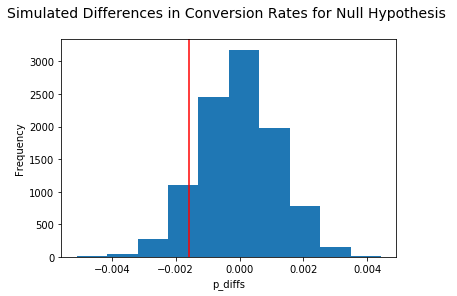

In [95]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title("Simulated Differences in Conversion Rates for Null Hypothesis \n", fontsize=14);
plt.axvline(treat_convert - control_convert, color='r');

Proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**

In [96]:
obs_diff = treat_convert - control_convert

(p_diffs > obs_diff).mean()

0.90580000000000005

__Results:__ The p-value calculated is 0.9058. This is far greater than the typical $\alpha$ level of 0.05 in business studies. (An $\alpha$ level of 0.05 indicates that we have a 5% chance of committing a Type I error if the null is true.) As such, we would fail to reject the null and conclude that there is not sufficient evidence to say that that there is a difference between the two values.


Comparison to built in t-test

Calculate number of rows for old and new


In [97]:
import statsmodels.api as sm

convert_old = df2.query(" landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query(" landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2[df2['group'] == 'control'].shape[0]
n_new = df2[df2['group'] == 'treatment'].shape[0]
convert_old

17489

`stats.proportions_ztest` to compute test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [98]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score, p_value)

1.31092419842 0.905058312759


The z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages

In [99]:
from scipy.stats import norm
# Tells us how significant our z-score is
print(norm.cdf(z_score))

# for our single-sides test, assumed at 95% confidence level, we calculate: 
print(norm.ppf(1-(0.05)))

0.905058312759
1.64485362695


__Answer:__

 - We find that the z-score of 1.31092419842 is less than the critical value of 1.64485362695. So, we accept the null hypothesis.
 - As regards the conversion rates of the old and new pages, we find that old pages are only minutely better than new pages.

<a id='regression'></a>
## Part III - A regression approach

Logistic Regression

Create dummy variables and add an intercept


In [100]:
df2['intercept'] = 1
df2[['control','treatment']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


Instantiate and fit the model

In [101]:
import statsmodels.api as sm

logit = sm.Logit(df2['converted'],df2[['intercept' ,'treatment']])
results = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [102]:
# Workaround for known bug with .summary() with updated scipy
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Oct 2018   Pseudo R-squ.:               8.077e-06
Time:                        12:50:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p-value (0.190) here remains above an $\alpha$ level of 0.05 but is different because this is a two tailed test. We will still reject the null in this situation.

As a quick demonstration with the bootstrapped information:

In [103]:
# Calculate area of lower tail
p_lower = (p_diffs < obs_diff).mean()

# Calculate area of upper tail
upper = p_diffs.mean() - obs_diff
p_upper = (p_diffs > upper).mean()

# Calculate total tail area
p_lower + p_upper

0.18980000000000002

__Add an additional variable to the model__

Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the `countries.csv` dataset and merge together your datasets on the approporiate rows. Here are the docs for joining tables.

In [109]:
countries_df = pd.read_csv('./countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [110]:
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


Confirm user countries

In [111]:
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

Build the dummy variables

In [112]:
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


Instantiate and fit the model

In [113]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 15 Oct 2018   Pseudo R-squ.:               1.521e-05
Time:                        12:57:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

__Results:__ Once again, the p-values for the countries are well above a 0.05 $\alpha$ level. And so we fail to reject the null and conclude that on it's own, there is no significant contribution from country to differences in conversion rates for the two pages.

Now to check for an interaction

In [115]:
df_new['CA_page'] = df_new['CA'] * df_new['treatment']
df_new['UK_page'] = df_new['UK'] * df_new['treatment']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment,CA,UK,US,CA_page,UK_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,0,1


In [116]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'treatment', 'CA', 'UK', 'CA_page', 'UK_page']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 15 Oct 2018   Pseudo R-squ.:               3.482e-05
Time:                        13:34:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
treatment     -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

__Results:__ None of the variables have significant p-values. Therefore, we will fail to reject the null and conclude that there is not sufficient evidence to suggest that there is an interaction between country and page received that will predict whether a user converts or not.

In the larger picture, based on the available information, we do not have sufficient evidence to suggest that the new page results in more conversions than the old page.

In [120]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0